In [152]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [153]:
# words = open('../dognames.txt').read().splitlines()
words = open('../names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [154]:
vocab_size = len(set(''.join(words))) + 1 # +1 for the padding symbol

chars = sorted(list(set(''.join(words)))) # sorted list of unique characters
chars = ['.'] + chars # add padding symbol to the beginning of the list
stoi = {c:i for i,c in enumerate(chars)} # char to index mapping
itos = {i:c for i,c in enumerate(chars)} # index to char mapping

print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [252]:
block_size = 3 # context size

# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        chs = '.' + w + '.'
        for ch1, ch2 in zip(chs, chs[1:]):
            context = context[1:] + [stoi[ch1]]
            # print(''.join(itos[i] for i in context), '->', ch2)
            X.append(context)
            Y.append(stoi[ch2])

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

# train, validation, test split

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [253]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([182484, 3]), torch.Size([22869, 3]), torch.Size([22793, 3]))

In [273]:
emb_dim = 10 # embedding dimension
# parameters
C = torch.randn((vocab_size, emb_dim), requires_grad=True)
W1 = torch.randn((block_size * emb_dim, 200), requires_grad=True)
B1 = torch.randn(200, requires_grad=True)
W2 = torch.randn((200, vocab_size), requires_grad=True)
B2 = torch.randn(vocab_size, requires_grad=True)
parameters = [C, W1, B1, W2, B2]

sum(p.nelement() for p in parameters)

11897

In [270]:
# hyperparameters
minibatch_size = 128
lr_train = 0.55

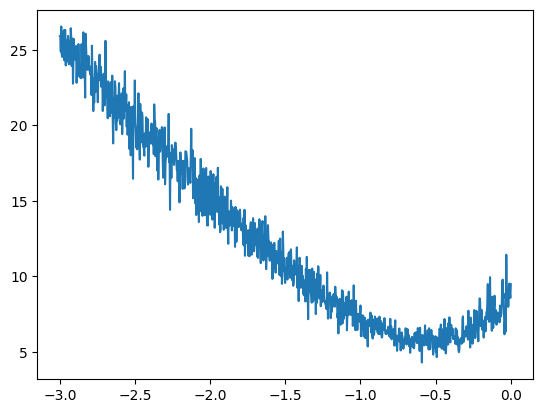

In [272]:
# search for the best learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lossi = []
# training loop
for i in range(1000):
    #  minibatch
    ix = torch.randint(0, X_train.shape[0], (minibatch_size,))
    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view((-1, block_size * emb_dim)) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad
    # track loss and learning rate
    lossi.append(loss.item())
    lri.append(lre[i])    

# determining the most efficient learning rate
plt.plot(lri, lossi)

In [274]:
lossi = []
stepi = []

In [275]:
# training loop
for i in range(200000):
    #  minibatch
    ix = torch.randint(0, X_train.shape[0], (minibatch_size,))
    # forward pass
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view((-1, block_size * emb_dim)) @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Y_train[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lr_train if i < 100000 else lr_train * 0.1
    for p in parameters:
        p.data -= lr * p.grad
    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

2.226919651031494


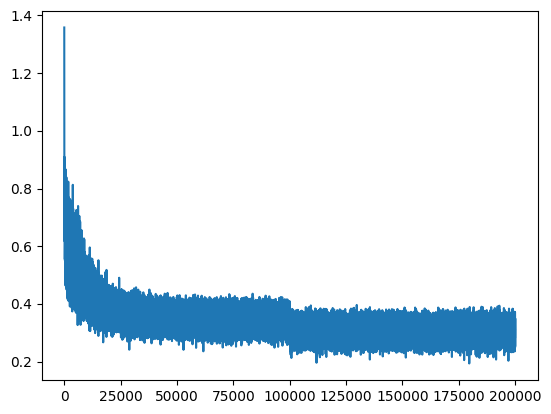

In [276]:
plt.plot(stepi, lossi)

In [277]:
# loss over the training set
emb = C[X_train]
h = torch.tanh(emb.view((-1, block_size * emb_dim)) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_train)
loss.item()

2.027056932449341

In [278]:
# loss over the validaton set
emb = C[X_val]
h = torch.tanh(emb.view((-1, block_size * emb_dim)) @ W1 + B1)
logits = h @ W2 + B2
loss = F.cross_entropy(logits, Y_val)
loss.item()

2.112422466278076

In [280]:
# generating names
for i in range(10):
    out = []
    ixs = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(ixs)]
        h = emb.view((1, block_size * emb_dim)) @ W1 + B1
        h = torch.tanh(h)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, replacement=True).item()
        if ix == 0:
            break
        ixs = ixs[1:] + [ix]
        out.append(itos[ix])
    print(''.join(out))

fiel
farie
ashanvik
pastiani
marleneva
ezelma
ezmanellea
emma
orin
bama


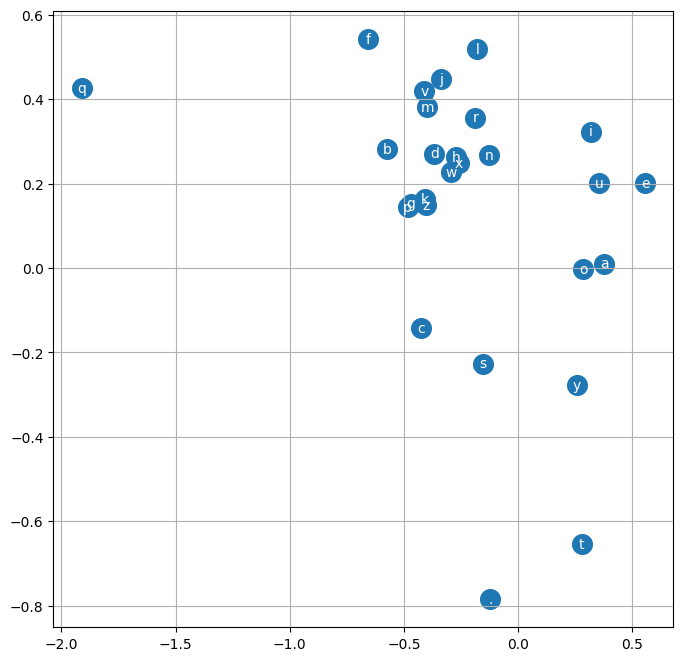

In [79]:
# 2D embeding visualization after training
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(vocab_size):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')